
# 빠른 의류 이미지 검색을 위한 Fashion-clip

## fashion-clip

In [1]:
%%capture
!pip install -U fashion-clip

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from fashion_clip.fashion_clip import FashionCLIP

In [4]:
%%capture
fclip = FashionCLIP('fashion-clip')

In [6]:
print(fclip.model)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

## Utils

- Cos_sim에 관하여 왜 float64를 썼는가?
    - 현재 embedding 결과는 **float32**이다. float32(32bit)는 유효숫자 6자리(0.xxxxxx)인데 내적과 나누기 연산를 진행하면 오차가 커지게 된다.
    - 그래서 float64가 되도록 바꿔줄 필요가 있다.

- 정규화
```
    image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
```




In [7]:
from typing import Callable
import os
import numpy as np
from tqdm import tqdm

# Good -> 2순위
def L2norm(a: np.ndarray, b=0):
    return np.linalg.norm(a - b)

# Good -> 1순위
def cos_sim(a: np.ndarray, b: np.ndarray):
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Good
def pearson_sim(a: np.ndarray, b: np.ndarray):
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    return np.dot((a - np.mean(a)), (b - np.mean(b))) / ((np.linalg.norm(a - np.mean(a))) * (np.linalg.norm(b - np.mean(b))))

# Bad
def jaccard_sim(a: np.ndarray, b: np.ndarray):
    intersection = np.intersect1d(a, b)
    union = np.union1d(a, b)
    similarity = len(intersection) / len(union)
    return similarity

# Bad
def covariance(a, b):
    return np.cov(a, b, ddof=1)


# dir안의 img_path들을 list로 출력 -> input_dir, output_dir의 list를 embedding하기 위해서 각각 만들어야함.
def dir2list(dir_path:str) -> list:
    img_list = []
    for file_name in tqdm(sorted(os.listdir(dir_path))):
        img_path = os.path.join(dir_path, file_name)
        img_list.append(img_path)
    return img_list


# 특정input_image에 대한 유사도에 따른 db 생성
def create_db(similarity: Callable, out_images: list, input_emb: np.array, output_embs: np.array):
    '''
    similarity: L2norm, cos_sim, pearson_sim 등 함수를 받는 인자
    images: image의 path를 가지고 있는 인자
    input_emb: 기준이 되는 embedding -> (사용자)post
    output_embs: 출력이 되는 제품들의 embedding
    '''
    db = []

    if similarity == L2norm:
        reverse = False
    else:
        reverse = True

    for img_path, emb in zip(out_images[:-1],output_embs):
        db.append((img_path, similarity(input_emb, emb)))

    db.sort(key=lambda x: x[1], reverse=reverse)

    return db

# input_images에 대한 유사도에 따른 db 생성
def create_all_db(similarity: Callable, input_images:list, out_images: list, input_embs: np.array, output_embs: np.array):
    '''
    similarity: L2norm, cos_sim, pearson_sim 등 함수를 받는 인자
    images: image의 path를 가지고 있는 인자
    input_embs: 입력이 되는 제품들의 embedding
    output_embs: 출력이 되는 제품들의 embedding
    '''
    product_db = {}

    if similarity == L2norm:
        reverse = False
    else:
        reverse = True

    for input_img_path, input_emb in zip(input_images, input_embs):
        input_id = int(input_img_path.split("/")[-1].split(".")[0])
        db = []
        for output_img_path, output_emb in zip(output_images,output_embs):
            db.append((output_img_path, similarity(input_emb, output_emb)))

        db.sort(key=lambda x: x[1], reverse=reverse)

        product_db[input_id] = db

    return product_db


# 시각화_ver1
def db_visual(db:list, start, end):
    '''
    db: input_image에 따른 유사도가 정렬된 리스트
    start, end: 시각화해서 볼 상품 지정
    '''
    for img_path, dis in db[start:end]:
        img = Image.open(img_path)
        fig, ax= plt.subplots(1, 2, figsize=(24, 12))
        ax[0].imshow(input_img)
        ax[0].set_title("original")
        ax[1].imshow(img)
        ax[1].set_title(f"{img_path}: {dis:.3f}")
        plt.show()

# 시각화_ver2
def db_visual(product_db:dict, input_num: int, input_images:list, start: int, end: int):
    db = product_db[input_num]
    input_img = Image.open(input_images[input_num])

    for img_path, dis in db[start:end]:
        img = Image.open(img_path)
        fig, ax= plt.subplots(1, 2, figsize=(20, 8))
        ax[0].imshow(input_img)
        ax[0].set_title("original")
        ax[1].imshow(img)
        ax[1].set_title(f"{img_path}: {dis:.3f}")
        plt.show()

## Dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


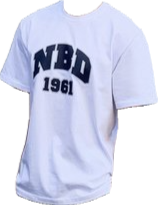

In [9]:
from PIL import Image

input_img = Image.open("/content/drive/MyDrive/top_test/input/000.png")

input_img

## Image Vectorizer 모델 로드

https://huggingface.co/patrickjohncyh/fashion-clip

In [10]:
input_images = dir2list("/content/drive/MyDrive/top_test/input")
output_images = dir2list("/content/drive/MyDrive/top_test/output")

print(len(input_images), len(output_images))

print(input_images[-1])

100%|██████████| 117/117 [00:00<00:00, 396392.22it/s]

22 117
/content/drive/MyDrive/top_test/input/021.png


## 임베딩

In [11]:
# we create image embeddings
input_embs = fclip.encode_images(input_images, batch_size=32)
output_embs = fclip.encode_images(output_images, batch_size=32)

1it [00:04,  4.82s/it]
4it [00:03,  1.19it/s]


In [12]:
print(output_images[0])

/content/drive/MyDrive/top_test/output/000.jpeg


In [ ]:
import pickle
SAVE_DIR = "/content/drive/MyDrive/top_test/embedding"
for image_path, output_emb in zip(output_images,output_embs):
    id = int(image_path.split("/")[-1].split(".")[0])
    with open(os.path.join(SAVE_DIR,f"{id:03}.pkl"), "wb") as f:
        pickle.dump(output_emb, f)

In [13]:
print(input_embs.shape, output_embs.shape)

a = np.dot(input_embs[0], output_embs[0])
input_emb64 = input_embs[0].astype(np.float64)
print(input_embs[0].dtype)
print(input_emb64.dtype)
print(a.dtype)

(22, 512) (117, 512)
float32
float64
float32


## 유사도에 따른 DB 생성

In [14]:
product_db = create_all_db(cos_sim, input_images, output_images, input_embs, output_embs)
product_db

{0: [('/content/drive/MyDrive/top_test/output/000.jpeg', 0.7543759268427216),
  ('/content/drive/MyDrive/top_test/output/064.jpeg', 0.5228135177859432),
  ('/content/drive/MyDrive/top_test/output/003.jpeg', 0.5181980300063959),
  ('/content/drive/MyDrive/top_test/output/056.jpeg', 0.5138499139448452),
  ('/content/drive/MyDrive/top_test/output/005.jpeg', 0.5035343158336014),
  ('/content/drive/MyDrive/top_test/output/096.jpeg', 0.4960516927096908),
  ('/content/drive/MyDrive/top_test/output/034.jpeg', 0.4866126067757127),
  ('/content/drive/MyDrive/top_test/output/077.jpeg', 0.48548267939801376),
  ('/content/drive/MyDrive/top_test/output/016.jpeg', 0.48398825112962807),
  ('/content/drive/MyDrive/top_test/output/002.jpeg', 0.4805240623007014),
  ('/content/drive/MyDrive/top_test/output/058.jpeg', 0.4799912564033969),
  ('/content/drive/MyDrive/top_test/output/054.jpeg', 0.4793809732437821),
  ('/content/drive/MyDrive/top_test/output/103.png', 0.47758402765900076),
  ('/content/drive/M

## 시각화

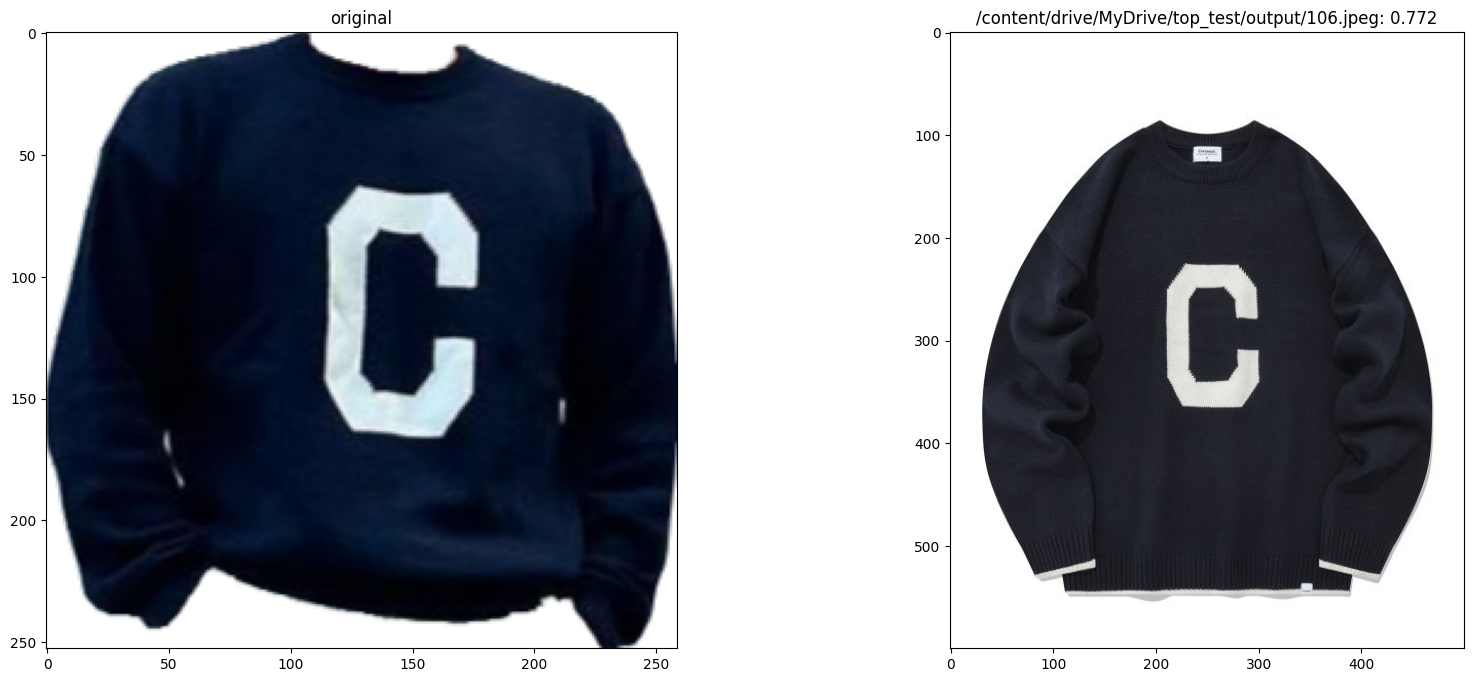

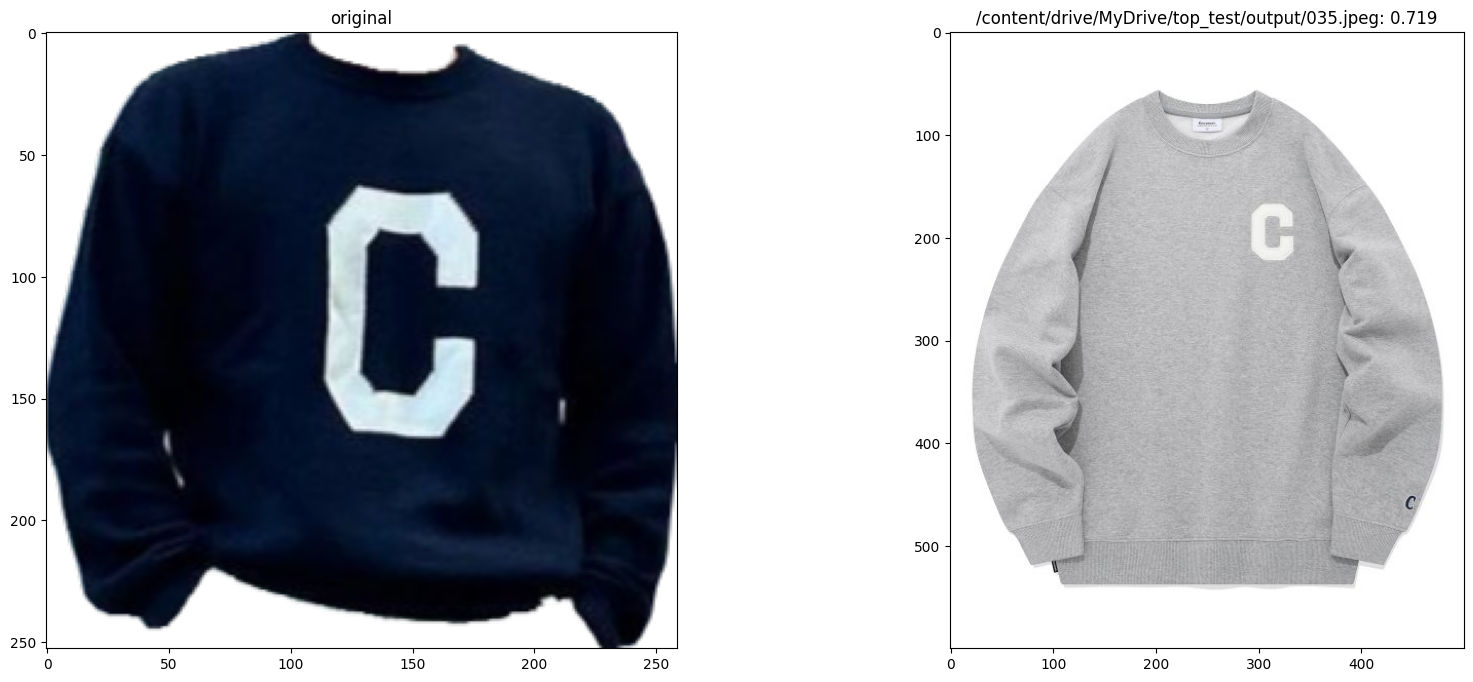

In [18]:
# 시각화
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def db_visual(product_db:dict, input_num: int, input_images:list, start: int, end: int):
    db = product_db[input_num]
    input_img = Image.open(input_images[input_num])

    for img_path, dis in db[start:end]:
        img = Image.open(img_path)
        fig, ax= plt.subplots(1, 2, figsize=(20, 8))
        ax[0].imshow(input_img)
        ax[0].set_title("original")
        ax[1].imshow(img)
        ax[1].set_title(f"{img_path}: {dis:.3f}")
        plt.show()

db_visual(product_db, 17, input_images, 0, 2)